In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math

#date, total_cases, new_cases_smoothed, total_deaths, new_deaths_smoothed, reproduction_rate, - Stefan
#new_tests_smoothed, positive_rate, total_vaccinations, people_vaccinated, new_vaccinations, new_vaccinations_smoothed, - Ion
#stringency_index, population, aged_70_older, gdp_per_capita, extreme_poverty, cardiovascular_death_rate, - Mirela
#diabetes_prevelance, female_smokers, male_smokers, handwashind_facilities, hospital_beds_per_thousand, life_expectancy, human_development_index - Dana


In [4]:
# Jupyter configuration
pd.set_option('display.max_rows', 500)

In [5]:
dataset = pd.read_csv('owid-covid-data.csv')

Separate the data into two datasets

In [6]:
moldova_dataset = dataset[dataset['location'] == 'Moldova']
moldova_dataset.to_csv('moldova-covid-data.csv')

dataset = moldova_dataset

In [7]:
# The shape of the dataset
dataset.shape

(604, 65)

### Variables description

| Variable                             | Description                                                                                                    |
|:-------------------------------------|:---------------------------------------------------------------------------------------------------------------|
| `icu_patients`                       | Number of COVID-19 patients in intensive care units (ICUs) on a given day                                      |
| `icu_patients_per_million`           | Number of COVID-19 patients in intensive care units (ICUs) on a given day per 1,000,000 people                 |
| `hosp_patients`                      | Number of COVID-19 patients in hospital on a given day                                                         |
| `hosp_patients_per_million`          | Number of COVID-19 patients in hospital on a given day per 1,000,000 people                                    |
| `weekly_icu_admissions`              | Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week                      |
| `weekly_icu_admissions_per_million`  | Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week per 1,000,000 people |
| `weekly_hosp_admissions`             | Number of COVID-19 patients newly admitted to hospitals in a given week                                        |
| `weekly_hosp_admissions_per_million` | Number of COVID-19 patients newly admitted to hospitals in a given week per 1,000,000 people                   |

### Policy responses
| Variable           | Description                                                                                                                                                                                                         |
|:-------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `stringency_index` | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response) |

### Reproduction rate
| Variable            | Description                                                                                                                                   |
|:--------------------|:----------------------------------------------------------------------------------------------------------------------------------------------|
| `reproduction_rate` | Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database |

### Tests & positivity
| Variable                          | Description                                                                                                                                                                                                                                                                                                          |
|:----------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_tests`                     | Total tests for COVID-19                                                                                                                                                                                                                                                                                             |
| `new_tests`                       | New tests for COVID-19 (only calculated for consecutive days)                                                                                                                                                                                                                                                        |
| `total_tests_per_thousand`        | Total tests for COVID-19 per 1,000 people                                                                                                                                                                                                                                                                            |
| `new_tests_per_thousand`          | New tests for COVID-19 per 1,000 people                                                                                                                                                                                                                                                                              |
| `new_tests_smoothed`              | New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `new_tests_smoothed_per_thousand` | New tests for COVID-19 (7-day smoothed) per 1,000 people                                                                                                                                                                                                                                                             |
| `positive_rate`                   | The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)                                                                                                                                                                                              |
| `tests_per_case`                  | Tests conducted per new confirmed case of COVID-19, given as a rolling 7-day average (this is the inverse of positive_rate)                                                                                                                                                                                          |
| `tests_units`                     | Units used by the location to report its testing data 

Looking at these variables one can observe that for some variables there are pair variables that end wirh 'per_thousand' or 'per_million'. These variables generalize the information regarding the variable that is represented by tehm. We can exclude these variables because they have the same behaviour as the real measurements. For example, icu_patients in a way represents the same information as variable icu_patients_per_million and should have the same behaviour. The variables to be excluded are: 

* icu_patients_per_million
* hosp_patients_per_million
* weekly_icu_admissions_per_million
* weekly_hosp_admissions_per_million
* total_tests_per_thousand
* new_tests_per_thousand
* new_tests_smoothed
* new_tests_smoothed_per_thousand.

In [8]:
#dataset.drop([
#        'icu_patients_per_million',
#        'hosp_patients_per_million', 
#        'weekly_icu_admissions_per_million',
#        'weekly_hosp_admissions_per_million',
#        'total_tests_per_thousand',
#        'new_tests_per_thousand',
#        'new_tests_smoothed',
#        'new_tests_smoothed_per_thousand'
#    ],
#    axis='columns',
#    inplace=True
#)

#dataset.shape

Select only a subset of variables to work with

In [9]:
dataset = dataset[[
    'location',
    'date',
    'new_tests_smoothed', 
    'positive_rate', 
    'total_vaccinations', 
    'people_vaccinated', 
    'new_vaccinations', 
    'new_vaccinations_smoothed'
]]

dataset.shape

(604, 8)

In [10]:
# All available variables
dataset.columns.tolist()

['location',
 'date',
 'new_tests_smoothed',
 'positive_rate',
 'total_vaccinations',
 'people_vaccinated',
 'new_vaccinations',
 'new_vaccinations_smoothed']

In [11]:
# Fixing date column datatype
dataset['date'] = pd.to_datetime(dataset['date'])

/tmp/ipykernel_7354/1142007443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = pd.to_datetime(dataset['date'])


In [12]:
# Variable types
dataset.dtypes

location                             object
date                         datetime64[ns]
new_tests_smoothed                  float64
positive_rate                       float64
total_vaccinations                  float64
people_vaccinated                   float64
new_vaccinations                    float64
new_vaccinations_smoothed           float64
dtype: object

#### There are two variables that are not numerical: date and tests_units. 

### Before dealing with missing values, let's take a look at the head and tail of the resulting dataset. 

In [13]:
dataset.head(10)

,location,date,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,new_vaccinations,new_vaccinations_smoothed
75112,Moldova,2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN
75113,Moldova,2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN
75114,Moldova,2020-03-10,NaN,NaN,NaN,NaN,NaN,NaN
75115,Moldova,2020-03-11,NaN,NaN,NaN,NaN,NaN,NaN
75116,Moldova,2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN
75117,Moldova,2020-03-13,NaN,NaN,NaN,NaN,NaN,NaN
75118,Moldova,2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN
75119,Moldova,2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN
75120,Moldova,2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN
75121,Moldova,2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
dataset.tail(10)

,location,date,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,new_vaccinations,new_vaccinations_smoothed
75706,Moldova,2021-10-23,9845.0,0.169,1485935.0,NaN,2292.0,4220.0
75707,Moldova,2021-10-24,8890.0,0.184,1486884.0,NaN,949.0,4201.0
75708,Moldova,2021-10-25,7936.0,0.205,NaN,NaN,NaN,4245.0
75709,Moldova,2021-10-26,NaN,NaN,1497461.0,NaN,NaN,3517.0
75710,Moldova,2021-10-27,NaN,NaN,1502791.0,NaN,5330.0,3764.0
75711,Moldova,2021-10-28,NaN,NaN,1508749.0,NaN,5958.0,4101.0
75712,Moldova,2021-10-29,NaN,NaN,NaN,NaN,NaN,4266.0
75713,Moldova,2021-10-30,NaN,NaN,1518261.0,NaN,NaN,4618.0
75714,Moldova,2021-10-31,NaN,NaN,1520548.0,NaN,2287.0,4809.0
75715,Moldova,2021-11-01,NaN,NaN,1525820.0,NaN,5272.0,4807.0


All of the numerical variables are represented by `pandas` library as floats64. This is fine because there are a lot of missing values and soon we will replace them with mean or median, depending on the skewness, and these will not be integer numbers. 

Let's for now take a look at all unique values from the `tests_units` column.

This variable since its not numerical, it might have a weak relation to the other numerical variables and will not help much further when the prediction will be made.

In [15]:
stats_df = dataset.describe();
stats_df.loc['skewness'] = dataset.skew();
stats_df.loc['kurtosis'] = dataset.kurt();
stats_df

/tmp/ipykernel_7354/876448626.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_df.loc['skewness'] = dataset.skew();
/tmp/ipykernel_7354/876448626.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_df.loc['kurtosis'] = dataset.kurt();


,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,new_vaccinations,new_vaccinations_smoothed
count,155.000000,155.000000,1.490000e+02,116.000000,112.000000,241.000000
mean,5682.251613,0.068194,6.475711e+05,285127.801724,8317.625000,6266.286307
std,1616.964820,0.067061,5.172161e+05,190810.881828,6919.944265,3651.044602
min,3681.000000,0.009000,3.849000e+03,3849.000000,900.000000,520.000000
25%,4588.500000,0.015000,1.503840e+05,96111.750000,3290.500000,3651.000000
50%,5211.000000,0.030000,5.777630e+05,331071.500000,6603.000000,5960.000000
75%,6097.500000,0.118500,1.034428e+06,458587.000000,10939.500000,8419.000000
max,12096.000000,0.271000,1.525820e+06,824986.000000,45233.000000,16176.000000
skewness,1.704139,1.092007,3.945227e-01,0.039349,2.089812,0.672894
kurtosis,3.366510,0.220778,-1.217733e+00,-1.100604,7.090763,-0.118985


In [16]:
def get_bins(n):
    return int(1 + 3.3 * math.log(n))

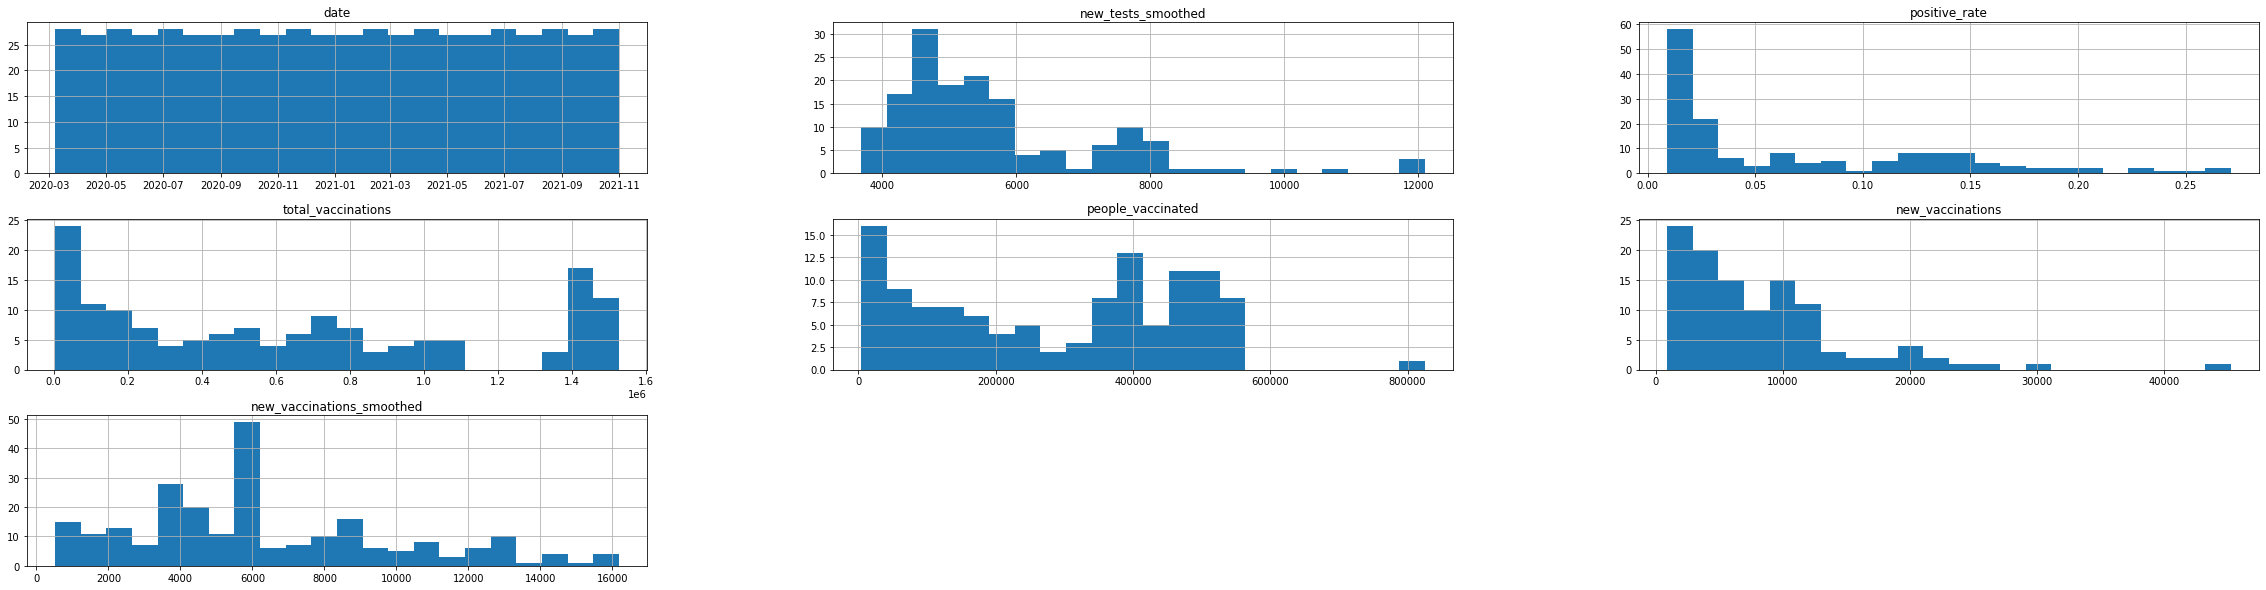

In [17]:
dataset_size = dataset.shape[0]
bins = get_bins(dataset_size)
dataset.hist(figsize=(40, 10), bins=bins);

### Time series plots